<small>**Step 0 — Import Required Libraries**  
We import all required Python libraries:  
- `pandas` & `numpy` for handling data  
- `pathlib.Path` for file paths  
- `scikit-learn` modules for model training, evaluation, and cross-validation  
- `matplotlib` for plotting  
- `DecisionTreeClassifier` & `RandomForestClassifier` for ML models</small>


In [8]:

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt


<small>**Step 2 — Define Features and Target**  
- `FEATURES` = independent variables (age, sex, chest pain type, etc.)  
- `TARGET` = dependent variable (1 = heart disease present, 0 = no disease)  
- We create `X` for features and `y` for labels, then split into train/test sets  
with stratified sampling to preserve the proportion of classes.</small>


In [9]:
FEATURES = ["age","sex","cp","trestbps","chol","fbs","restecg",
            "thalach","exang","oldpeak","slope","ca","thal"]
TARGET = "target"

In [10]:
df=pd.read_csv('heart.csv')

<small>Extract features (`X`) and target labels (`y`) from the dataframe.  
Convert `y` to integer type so that scikit-learn can process it without issues.</small>


In [11]:
X = df[FEATURES]
y = df[TARGET].astype(int)

<small>**Split the dataset into training and testing sets**  
- `test_size=0.2` → 20% of data for testing  
- `random_state=42` → ensures reproducible splits  
- `stratify=y` → preserves the proportion of classes in train and test sets</small>


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

<small>**Check dataset dimensions and target distribution**  
- `X.shape` → shows the number of rows and features  
- `y.value_counts()` → shows how many samples belong to each class  
Helps verify there are no unexpected issues after preprocessing.</small>


In [13]:
X.shape, y.value_counts()

((1025, 13),
 target
 1    526
 0    499
 Name: count, dtype: int64)

<small>**Prepare for Decision Tree depth tuning**  
- `depths = range(2, 11)` → test maximum depths from 2 to 10  
- `StratifiedKFold` with 5 splits ensures each fold keeps the same class ratio,  
  and `shuffle=True` randomizes data before splitting for better generalization.</small>


In [14]:
depths = list(range(2, 11))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [15]:
cv_scores = []

<small>**Evaluate Decision Tree for each candidate depth**  
- For each `d` in `depths`, create a `DecisionTreeClassifier` with that `max_depth`  
- Perform cross-validation (`cross_val_score`) using the `cv` object defined earlier  
- Store the mean accuracy in `cv_scores` for later comparison</small>


In [16]:
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    score = cross_val_score(clf, X, y, cv=cv).mean()
    cv_scores.append(score)

<small>**Find the best-performing depth**  
- Use `np.argmax(cv_scores)` to get the index of the highest CV score  
- Retrieve the corresponding `max_depth` from `depths`  
- Display both the chosen depth and the list of all CV scores for reference</small>


In [17]:
best_depth = depths[int(np.argmax(cv_scores))]
best_depth, cv_scores

(10,
 [np.float64(0.744390243902439),
  np.float64(0.8302439024390245),
  np.float64(0.8497560975609757),
  np.float64(0.9043902439024392),
  np.float64(0.9512195121951219),
  np.float64(0.9707317073170731),
  np.float64(0.9882926829268293),
  np.float64(0.9970731707317073),
  np.float64(0.9980487804878049)])

<small>**Visualize cross-validation accuracy vs. tree depth**  
- X-axis: `max_depth` values tested  
- Y-axis: mean CV accuracy for each depth  
- The plot helps identify where accuracy peaks and whether deeper trees cause overfitting</small>


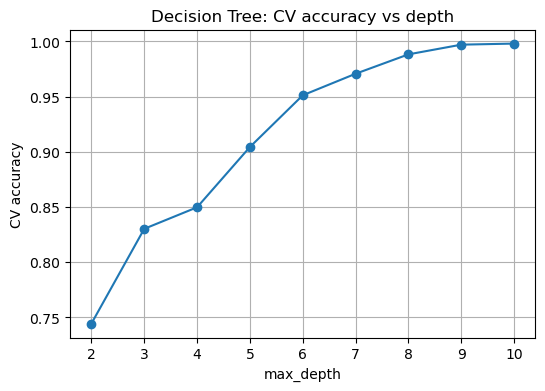

In [18]:
plt.figure(figsize=(6,4))
plt.plot(depths, cv_scores, marker="o")
plt.xlabel("max_depth")
plt.ylabel("CV accuracy")
plt.title("Decision Tree: CV accuracy vs depth")
plt.grid(True)
plt.show()

<small>**Train the Decision Tree with the best depth**  
- Use `best_depth` found from cross-validation  
- `random_state=42` ensures reproducibility  
- Fit the model on the training set (`X_train`, `y_train`)</small>


In [19]:
dt = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)


<small>**Evaluate the Decision Tree on the test set**  
- Predict labels for `X_test` using `dt.predict()`  
- Calculate accuracy with `accuracy_score`  
- Show detailed precision, recall, and F1-score per class using `classification_report`</small>


In [20]:
y_pred_dt = dt.predict(X_test)
print("Decision Tree accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

Decision Tree accuracy: 0.9853658536585366
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       100
           1       1.00      0.97      0.99       105

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



<small>**Visualize the trained Decision Tree**  
- `plot_tree()` displays the structure of the tree, including feature splits and thresholds  
- `feature_names` and `class_names` make the plot interpretable  
- `filled=True` colors the nodes by class probability, and `rounded=True` improves readability  
- `fontsize=9` keeps labels compact for large trees</small>


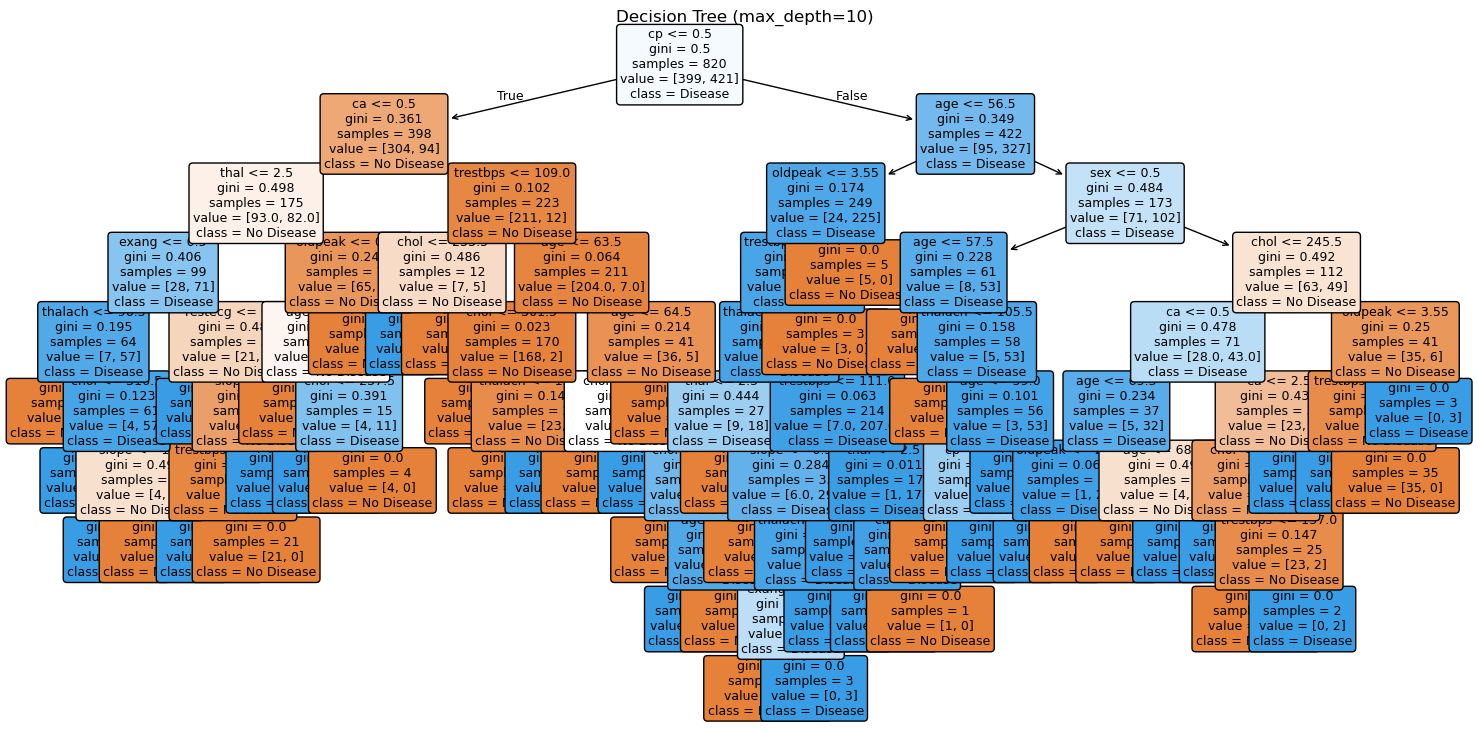

In [21]:
plt.figure(figsize=(18, 9))
plot_tree(
    dt,
    feature_names=FEATURES,
    class_names=["No Disease","Disease"],
    filled=True, rounded=True, fontsize=9
)
plt.title(f"Decision Tree (max_depth={best_depth})")
plt.show()

<small>**Export Decision Tree to Graphviz format**  
- `export_graphviz()` generates a `.dot` file containing the tree structure  
- This file can be rendered with Graphviz tools (e.g., `dot -Tpng tree.dot -o tree.png`) for high-quality visuals  
- `special_characters=True` allows rendering of special symbols in labels</small>


In [22]:
export_graphviz(
    dt,
    out_file="tree.dot",
    feature_names=FEATURES,
    class_names=["0","1"],
    filled=True, rounded=True, special_characters=True
)
print("Saved Graphviz file: tree.dot")

Saved Graphviz file: tree.dot


<small>**Step 8 — Train and evaluate a Random Forest (baseline)**  
- `n_estimators=300` → number of trees in the forest  
- `max_depth=None` → trees expand until all leaves are pure or min_samples split is reached  
- `n_jobs=-1` → use all CPU cores for faster training  
- Fit the model on the training set, then evaluate on the test set with accuracy and classification report</small>


In [ ]:

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("Random Forest accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



<small>**Step 9 — Feature importances from Random Forest**  
- Extract `feature_importances_` from the trained Random Forest and store in a pandas Series  
- Sort in descending order to see the most influential features first  
- Plot a horizontal bar chart for easy interpretation, with the most important features at the top</small>


cp          0.148553
thalach     0.117392
ca          0.113613
oldpeak     0.105754
thal        0.095931
age         0.090881
chol        0.079279
exang       0.073692
trestbps    0.070837
slope       0.044162
sex         0.030348
restecg     0.019776
fbs         0.009782
dtype: float64

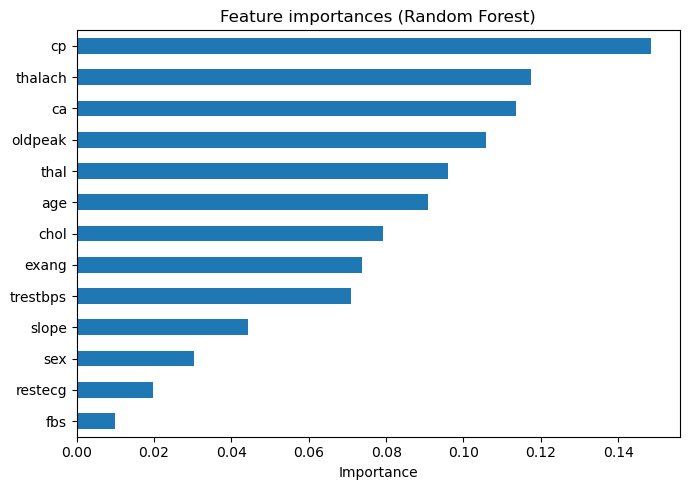

In [ ]:

importances = pd.Series(rf.feature_importances_, index=FEATURES).sort_values(ascending=False)
display(importances)

plt.figure(figsize=(7,5))
importances.plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Feature importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


<small>**Step 10 — Cross-validation accuracy comparison (Decision Tree vs. Random Forest)**  
- Use the same `cv` (StratifiedKFold) for both models to ensure a fair comparison  
- Compute mean CV accuracy for each model using `cross_val_score`  
- Compare results to see if the ensemble model (Random Forest) offers a performance gain over the single Decision Tree</small>


In [ ]:

dt_cv = cross_val_score(dt, X, y, cv=cv).mean()
rf_cv = cross_val_score(rf, X, y, cv=cv).mean()
print("CV accuracy — Decision Tree:", dt_cv)
print("CV accuracy — Random Forest:", rf_cv)


CV accuracy — Decision Tree: 0.9980487804878049
CV accuracy — Random Forest: 0.9960975609756098
